# Import packages

In [1]:
import cv2
import csv
import numpy as np
import os
import sklearn
import warnings
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, ELU, Dropout, Conv2D, BatchNormalization
from sklearn.model_selection import train_test_split

warnings.filterwarnings("always")

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size c

# Prepare Training Data

In [2]:
def prepare_data(csv_path):
    folder_name = csv_path.split("/")[0]
    center_imgs = []
    left_imgs = []
    right_imgs = []
    steer_angles = []
    with open(csv_path) as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
            #line: center, left, right, steering angle, throttle, break, speed
            center_imgs.append(folder_name + "/" + line[0].strip())
            left_imgs.append(folder_name + "/" + line[1].strip())
            right_imgs.append(folder_name + "/" + line[2].strip())
            steer_angles.append(float(line[3].strip()))
    return (center_imgs, left_imgs, right_imgs, steer_angles)

## Self generate data 0: official data

In [3]:
csv_path_0 = 'data/driving_log.csv'
center_paths_0, left_paths_0, right_paths_0, steer_angles_0 = prepare_data(csv_path_0)

### Explore data

In [4]:
center_paths_0[:3]

['data/IMG/center_2016_12_01_13_30_48_287.jpg',
 'data/IMG/center_2016_12_01_13_30_48_404.jpg',
 'data/IMG/center_2016_12_01_13_31_12_937.jpg']

In [5]:
left_paths_0[:3]

['data/IMG/left_2016_12_01_13_30_48_287.jpg',
 'data/IMG/left_2016_12_01_13_30_48_404.jpg',
 'data/IMG/left_2016_12_01_13_31_12_937.jpg']

In [6]:
right_paths_0[:3]

['data/IMG/right_2016_12_01_13_30_48_287.jpg',
 'data/IMG/right_2016_12_01_13_30_48_404.jpg',
 'data/IMG/right_2016_12_01_13_31_12_937.jpg']

In [7]:
steer_angles_0[:3]

[0.0, 0.0, 0.0]

## Self generate data 1: normal track

In [8]:
csv_path_1 = 'new_data/driving_log.csv'
center_paths_1, left_paths_1, right_paths_1, steer_angles_1 = prepare_data(csv_path_1)

### Explore data

In [9]:
center_paths_1[:3]

['new_data/IMG/center_2018_07_28_20_01_54_910.jpg',
 'new_data/IMG/center_2018_07_28_20_01_54_979.jpg',
 'new_data/IMG/center_2018_07_28_20_01_55_048.jpg']

In [10]:
left_paths_1[:3]

['new_data/IMG/left_2018_07_28_20_01_54_910.jpg',
 'new_data/IMG/left_2018_07_28_20_01_54_979.jpg',
 'new_data/IMG/left_2018_07_28_20_01_55_048.jpg']

In [11]:
right_paths_1[:3]

['new_data/IMG/right_2018_07_28_20_01_54_910.jpg',
 'new_data/IMG/right_2018_07_28_20_01_54_979.jpg',
 'new_data/IMG/right_2018_07_28_20_01_55_048.jpg']

In [12]:
steer_angles_1[:3]

[-0.03766214, -0.03766214, -0.03766214]

## Self generate data 2: reverse track

In [13]:
csv_path_2 = 'new_data_reverse/driving_log.csv'
center_paths_2, left_paths_2, right_paths_2, steer_angles_2 = prepare_data(csv_path_2)

### Explore data

In [14]:
center_paths_2[:3]

['new_data_reverse/IMG/center_2018_07_28_20_11_08_197.jpg',
 'new_data_reverse/IMG/center_2018_07_28_20_11_08_266.jpg',
 'new_data_reverse/IMG/center_2018_07_28_20_11_08_338.jpg']

In [15]:
left_paths_2[:3]

['new_data_reverse/IMG/left_2018_07_28_20_11_08_197.jpg',
 'new_data_reverse/IMG/left_2018_07_28_20_11_08_266.jpg',
 'new_data_reverse/IMG/left_2018_07_28_20_11_08_338.jpg']

In [16]:
right_paths_2[:3]

['new_data_reverse/IMG/right_2018_07_28_20_11_08_197.jpg',
 'new_data_reverse/IMG/right_2018_07_28_20_11_08_266.jpg',
 'new_data_reverse/IMG/right_2018_07_28_20_11_08_338.jpg']

In [17]:
steer_angles_2[:3]

[0.02273732, 0.0455852, 0.08671138]

## Merge training data together

In [18]:
all_paths = []
all_paths.extend(center_paths_0)
all_paths.extend(left_paths_0)
all_paths.extend(right_paths_0)
all_paths.extend(center_paths_1)
all_paths.extend(left_paths_1)
all_paths.extend(right_paths_1)
all_paths.extend(center_paths_2)
all_paths.extend(left_paths_2)
all_paths.extend(right_paths_2)

all_angles = []
correction = 0.2
all_angles.extend(steer_angles_0)
all_angles.extend([angle + correction for angle in steer_angles_0])
all_angles.extend([angle - correction for angle in steer_angles_0])
all_angles.extend(steer_angles_1)
all_angles.extend([angle + correction for angle in steer_angles_1])
all_angles.extend([angle - correction for angle in steer_angles_1])
all_angles.extend(steer_angles_2)
all_angles.extend([angle + correction for angle in steer_angles_2])
all_angles.extend([angle - correction for angle in steer_angles_2])


In [19]:
len(all_paths)

51210

In [20]:
len(all_angles)

51210

In [21]:
samples = list(zip(all_paths, all_angles))

In [22]:
# Show the samples data steering distribution

import matplotlib.pyplot as plt
%matplotlib inline

def show_steering(y_train):
    max_degree = 25
    degree_per_steering =10
    n_classes = max_degree * degree_per_steering
    plt.hist(y_train, bins = n_classes, histtype='bar', color='blue', rwidth=0.6, label='train')
    plt.show()


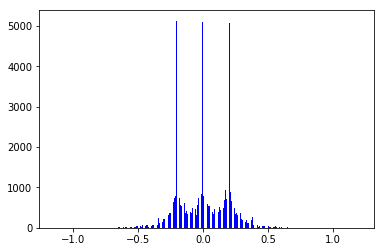

In [23]:
show_steering(all_angles)

# Define Model Architecture

In [24]:
def resize(img):
    import tensorflow
    return tensorflow.image.resize_images(img, (60, 120))

In [25]:
def nvidia_car_model():
    """
    Implementation of nvidia autonomous car model
    """

    # Prepreocessing layers
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape = (160, 320, 3)))
    model.add(Cropping2D(cropping = ((50, 20), (0,0))))

    # Main network
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    return model

# Training

## Create Training set and validation set

In [26]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [27]:
len(train_samples)

40968

In [28]:
len(validation_samples)

10242

## Create model

In [29]:
model = nvidia_car_model()

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  if sys.path[0] == '':
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
  del sys.path[0]
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/i

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

## Complile model

In [31]:
model.compile(loss = 'mse', optimizer = 'adam')

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signatur

## Define generator to save memory

In [32]:
def my_generator(samples, batch_size = 28):
    """
    generate batch, batch_size is very important, if it's too large, GPU will run super slow
    """

    # Total number of samples
    num_samples = len(samples)

    # Using yeild to output batch result, until gothough all data in samples
    while True:

        # Random shuflling of Samples
        samples = sklearn.utils.shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset : offset + batch_size]

            images = []
            angles = []

            for image_path, angle in batch_samples:
                # Get image
                original_image = cv2.imread(image_path)

                # Convert color space from BGR to RGB
                image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

                images.append(image)
                angles.append(angle)

                # Data augmentation: flipping, add more data
                images.append(cv2.flip(image, 1))
                angles.append(angle * -1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [33]:
train_generator = my_generator(train_samples)
validation_generator = my_generator(validation_samples)

## Train the model

In [34]:
history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_samples),
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples),
                                     nb_epoch = 1,
                                     verbose = 1)

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=10242, epochs=1, verbose=1, steps_per_epoch=40968, validation_data=<generator...)`
  
/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature()

Epoch 1/1
40968/40968 [==============================] - 3143s 77ms/step - loss: 0.0051 - val_loss: 0.0061


## Save the model

In [35]:
model.save('model.h5')

In [36]:
print("Loss", history_object.history['loss'])
print("Validation Loss", history_object.history['val_loss'])

Loss [0.005117518820828475]
Validation Loss [0.0060700615720531]
